# HDF-N master catalogue
## Preparation of Ultradeep-Ks-GOODS-N data

The catalogue comes from `dmu0_Ultradeep-Ks-GOODS-N`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The total flux.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "ultradeep_ra"
DEC_COL = "ultradeep_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'Num': "ultradeep_id",
        'RAdeg': "ultradeep_ra",
        'DEdeg': "ultradeep_dec",
        'F_Ks': "f_ultradeep-wircam_k", #WIRCAM Ks prior
        'e_F_Ks': "ferr_ultradeep-wircam_k",
        'F_3.6': "f_ultradeep-irac_i1",
        'e_F3.6': "ferr_ultradeep-irac_i1",
        'F_4.5': "f_ultradeep-irac_i2",
        'e_F_4.5': "ferr_ultradeep-irac_i2",
        'F_5.8': "f_ultradeep-irac_i3",
        'e_F_5.8': "ferr_ultradeep-irac_i3",
        'F_8.0': "f_ultradeep-irac_i4",
        'e_F_8.0': "ferr_ultradeep-irac_i4",
    })


catalogue = Table.read("../../dmu0/dmu0_Ultradeep-Ks-GOODS-N/data/Ultradeep_Ks_GOODS-N_HELP-coverage.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2010 #Year of publication

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        
        #Replace 0.0 with nan
        catalogue[col][np.isclose(catalogue[col], 0.0)] = np.nan
        catalogue[errcol][np.isclose(catalogue[errcol], 0.0)] = np.nan
        
        #Calculate mags, errors 
        mag, error = flux_to_mag(np.array(catalogue[col])*1.e-6, np.array(catalogue[errcol] )*1.e-6)
          
        # magnitudes are added
        catalogue.add_column(Column(mag, name="m{}".format(col[1:])))
        catalogue.add_column(Column(error, name="m{}".format(errcol[1:])))

        #Add nan aperture columns
        #catalogue.add_column(Column(np.full(len(catalogue), np.nan, dtype=float), name="f_ap{}".format(col[1:])))
        #catalogue.add_column(Column(np.full(len(catalogue), np.nan, dtype=float), name="ferr_ap{}".format(col[1:])))
        #catalogue.add_column(Column(np.full(len(catalogue), np.nan, dtype=float), name="m_ap{}".format(col[1:])))
        #catalogue.add_column(Column(np.full(len(catalogue), np.nan, dtype=float), name="merr_ap{}".format(col[1:])))
        
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [6]:
catalogue[:10].show_in_notebook()

idx,ultradeep_id,ultradeep_ra,ultradeep_dec,f_ultradeep-wircam_k,ferr_ultradeep-wircam_k,f_ultradeep-irac_i1,ferr_ultradeep-irac_i1,f_ultradeep-irac_i2,ferr_ultradeep-irac_i2,f_ultradeep-irac_i3,ferr_ultradeep-irac_i3,f_ultradeep-irac_i4,ferr_ultradeep-irac_i4,m_ultradeep-wircam_k,merr_ultradeep-wircam_k,flag_ultradeep-wircam_k,m_ultradeep-irac_i1,merr_ultradeep-irac_i1,flag_ultradeep-irac_i1,m_ultradeep-irac_i2,merr_ultradeep-irac_i2,flag_ultradeep-irac_i2,m_ultradeep-irac_i3,merr_ultradeep-irac_i3,flag_ultradeep-irac_i3,m_ultradeep-irac_i4,merr_ultradeep-irac_i4,flag_ultradeep-irac_i4
0,1,188.953274,61.928625,nan,1.705,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
1,2,189.307965,61.928952,nan,1.865,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
2,3,189.348525,61.929005,nan,1.946,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
3,4,189.334236,61.929213,nan,1.829,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
4,5,189.290732,61.929309,3.883,1.643,nan,nan,nan,nan,nan,nan,nan,nan,22.4270815236,0.45940370446,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
5,6,189.144188,61.929338,1.542,0.723,nan,nan,nan,nan,nan,nan,nan,nan,23.4297890657,0.509070866433,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
6,7,188.896435,61.928964,nan,1.73,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
7,8,189.155729,61.92937,4.782,1.616,nan,nan,nan,nan,nan,nan,nan,nan,22.2009760706,0.366907090525,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
8,9,189.079731,61.929367,nan,0.668,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
9,10,189.220343,61.929417,11.037,1.823,nan,nan,nan,nan,nan,nan,nan,nan,21.2928723936,0.179332889488,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:

SORT_COLS = ['merr_ultradeep-wircam_k', 
             'merr_ultradeep-irac_i1', 
             'merr_ultradeep-irac_i2', 
             'merr_ultradeep-irac_i3',
             'merr_ultradeep-irac_i4']
FLAG_NAME = 'ultradeep_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 94930 sources.
The cleaned catalogue has 94930 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_HDF-N.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

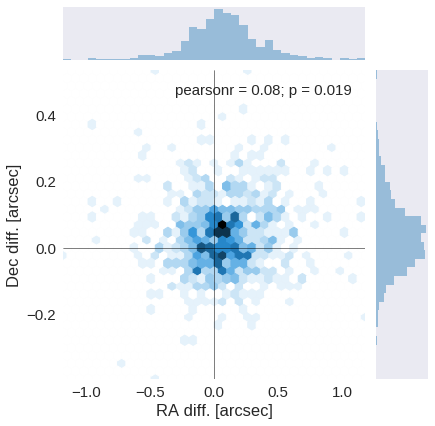

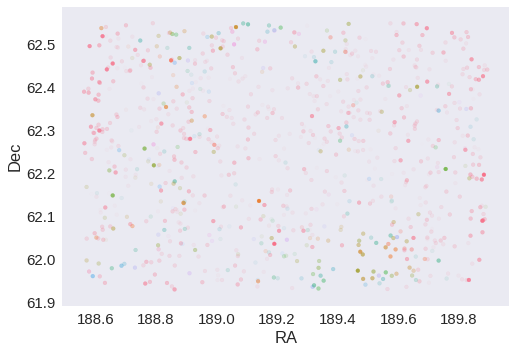

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.07018150315616367 arcsec
Dec correction: -0.02818903770247516 arcsec


In [11]:
catalogue[RA_COL] = catalogue[RA_COL] + delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL]  + delta_dec.to(u.deg)

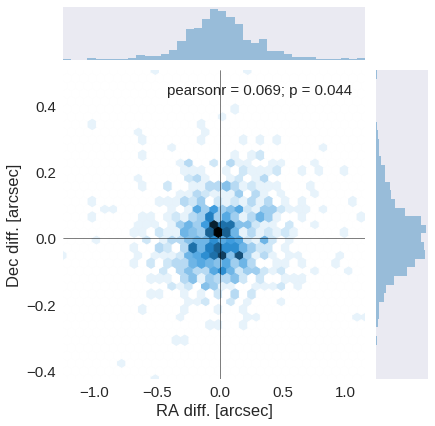

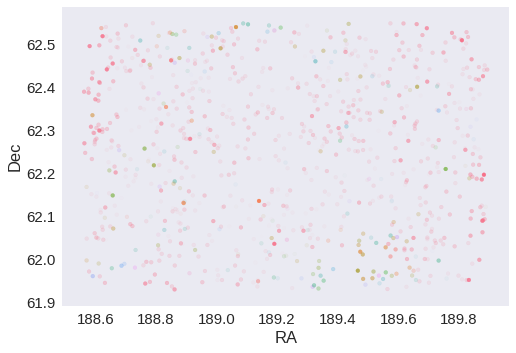

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "ultradeep_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

888 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/Ultradeep.fits".format(OUT_DIR), overwrite=True)